In [1]:
import matplotlib.pyplot as plt

from fitting import create_ensemble, load_data, create_datasets
import torch


labels = ["x (mm)", r"$p_x$ (mrad)","y (mm)",r"$p_y$ (mrad)",
          "z (mm)",r"$\delta\ (10^{-3})$"]

tkwargs = {"dtype": torch.float}
save_dir = "double_small_emittance_case_cov_term_no_energy_spread"
quad_strengths, image_data, bins, xx, _ = load_data()
train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)

n_particles = 100000
ensemble[0].beam.set_base_beam(
    ensemble[0].beam.base_dist,
    n_particles,
    p0c=torch.tensor(10.0e6)
)

ensemble.cuda();

C:\ProgramData\Miniconda3\envs\phase_space_reconstruction\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


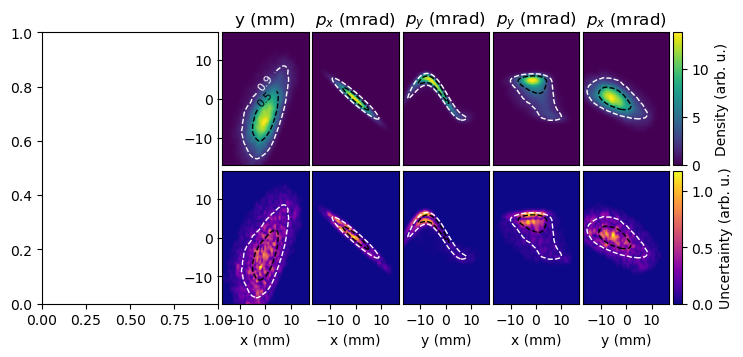

In [2]:
# compare reconstruction to slit scan measurement
import numpy as np
from scipy.ndimage import median_filter, gaussian_filter
import matplotlib.colors as colors
from matplotlib.ticker import LogFormatter
from matplotlib.lines import Line2D

from phase_space_reconstruction.utils import calculate_ellipse
from phase_space_reconstruction.visualization import add_ellipse

# create main figure
fig = plt.figure(figsize=(8,3.5))

fpath = ""

beam_coords = torch.load(save_dir + "/gt_beam.pt")
pairs = [[0,2],[0,1],[2,3],[0,3],[2,1]]

# specify gridspec
gridspec_kw={
        "right": 0.9,"hspace":0.05,"left":0.1,"top":0.925,"bottom":0.15,"wspace":0.05,
        "width_ratios":[*[1.0] * (len(pairs) + 2),0.1]
    }
spec = fig.add_gridspec(2, 2 + len(pairs) + 1, **gridspec_kw)

# add axes
ax0 = fig.add_subplot(spec[:2,:2])

ax = np.empty((2, len(pairs)+1), dtype=plt.Axes)
for ii in range(len(pairs)+1):
    ax[:,ii] = np.array([
        fig.add_subplot(spec[0, 2 + ii]),
        fig.add_subplot(spec[1, 2 + ii])]
    )



for n, pair in enumerate(pairs):
    meas_x = beam_coords[:,pair[0]].detach().cpu().numpy()*1e3
    meas_y = beam_coords[:,pair[1]].detach().cpu().numpy()*1e3

    half_size = 15
    median_filter_size = 3
    n_bins = 200
    #x1 = np.linspace(-half_size,half_size,150)
    x1 = np.linspace(-17.0,17.0,n_bins)
    x2 = np.linspace(-17.0,17.0,n_bins)

    h_slitscan, xe, ye = np.histogram2d(meas_x, meas_y, bins=[x1,x2], density=True)

    reconstruction_images = []
    for i in range(10,20):
        with torch.no_grad():
            initial_beam = ensemble[i].beam()
        reconstruction_coords = initial_beam.data

        reconstruct_x = reconstruction_coords[:,pair[0]].detach().cpu().numpy()*1e3
        reconstruct_y = reconstruction_coords[:,pair[1]].detach().cpu().numpy()*1e3

        h_reconstruction, xe, ye = np.histogram2d(reconstruct_x, reconstruct_y,
                                              bins=[x1,x2], density=True)
        h_reconstruction = gaussian_filter(h_reconstruction, median_filter_size,
                                           truncate=10.0)
        reconstruction_images += [h_reconstruction]

    reconstruction_mean = np.array(reconstruction_images).mean(axis=0)*1e3
    reconstruction_std = np.array(reconstruction_images).std(axis=0)*1e3

    # gt stats for ellipse plotting
    gt_mean_coords= torch.tensor((meas_x.mean(), meas_y.mean()))
    gt_cov = torch.stack([torch.tensor(ele) for ele in [meas_x,meas_y]]).cov()


    recon_mean_coords= torch.tensor((reconstruct_x.mean(), reconstruct_y.mean()))
    recon_cov = torch.stack([torch.tensor(ele) for ele in [reconstruct_x,
                                                        reconstruct_y]]).cov()
    #reconstruction_ellipse = create_ellipse(recon_mean_coords.numpy(), recon_cov
    # .numpy())


    h_slitscan = gaussian_filter(h_slitscan,median_filter_size,truncate=10.0)

    # get cdf of densities
    vmax = h_slitscan.max()
    test_levels = np.linspace(0, vmax, 1000)
    # for each level calculate the fractional sum
    total = h_slitscan.sum()

    sums = []
    for ele in test_levels:
        sums += [np.where(h_slitscan >= ele, h_slitscan, 0.0).sum() / total]
    sums = np.array(sums)

    # calculate levels
    quantiles = [0.5,0.9]
    levels = []
    for ele in quantiles[::-1]:
        diff = sums - ele
        levels += [test_levels[np.where(np.diff(np.sign(diff)))]]

    x1c = (xe[:-1] + xe[1:]) / 2
    x2c = (ye[:-1] + ye[1:]) / 2

    X, Y = np.meshgrid(xe,ye)
    Xc, Yc = np.meshgrid(x1c,x2c)

    d = [reconstruction_mean,reconstruction_std]# / (reconstruction_mean + 1e-10)]
    max_mean = reconstruction_mean.max()
    max_std = reconstruction_std.max()
    for i in range(2):#zip(ax, [reconstruction_mean,reconstruction_std]):
        if i == 1:
            # plot uncertainty
            c1 = ax[i][n].pcolor(X, Y, d[i].T,
                vmax=max_std,cmap="plasma",
                #norm=colors.LogNorm(vmin=1e-2, vmax=d[i].max())
            )
            ticks = np.array([0.1,0.25,0.5,1.0])
            formatter = LogFormatter(10, labelOnlyBase=False)
            #cbar = fig.colorbar(c1,ax=ax[i])#,ticks=ticks)

        else:
            # plot mean
            c0 = ax[i][n].pcolor(X, Y, d[i].T,vmax=max_mean)


        clevels = np.array(levels).flatten()
        c2 = ax[i,n].contour(Xc, Yc, h_slitscan.T, levels=clevels,
                             colors=["white","black"],linestyles="dashed",
                            zorder=3,linewidths=1)
        if n == 0 and i == 0:
            ax[i,n].clabel(
                c2, inline=True, fontsize=8,
                fmt=dict(zip(clevels,[f"{ele}" for ele in quantiles[::-1]])),
                manual=[[-10,10],[0,0]]
            )

        custom_lines = []
        for j in range(len(clevels)):
            lc = c2.collections[j].get_edgecolor()
            custom_lines += [Line2D([0],[0], color=lc)]
        #ax[i,n].legend(custom_lines, quantiles[::-1])

        #ax[i][n].set_ylabel(labels[pair[1]])
        ax[i][n].yaxis.labelpad = 0
        if n > 0:
            ax[i,n].set_yticks([])

        ax[0,n].set_xticks([])

    ax[0][n].set_title(labels[pair[1]])
    ax[-1][n].set_xlabel(labels[pair[0]])

cbar0 = fig.colorbar(c0, cax=ax[0,-1])
cbar1 = fig.colorbar(c1, cax=ax[1,-1])
cbar0.set_label("Density (arb. u.)")
cbar1.set_label("Uncertainty (arb. u.)")

for ele in ax.flatten():
    ele.collections[0].set_rasterized(True)




#fig.savefig(f"reconstruction_comparison_{save_dir}.svg")
#fig.savefig(f"reconstruction_comparison_{save_dir}.png", dpi=300)

<ErrorbarContainer object of 3 artists>

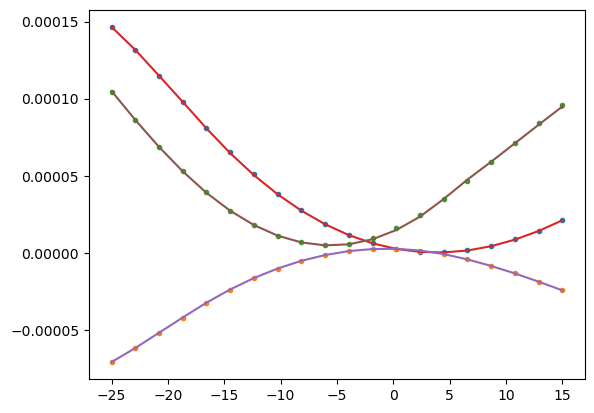

In [3]:
from phase_space_reconstruction.utils import calculate_ellipse
# calculate rms stats from each image
covs = []
for ele in image_data.transpose(-1,-2):
    centroid, cov = calculate_ellipse(ele, bins, bins)
    covs += [cov]

covs = torch.stack(covs)

# plot reconstruction covs
with torch.no_grad():
    predictions = []
    for i in range(20):
        ensemble = ensemble.cpu()
        p, _, _ = ensemble[i](quad_strengths[:,0,:].cpu())
        predictions += [p]

predictions = torch.stack(predictions).cpu().transpose(0,1)
rcovs = []
for ele in predictions.transpose(-1,-2):
    centroid, cov = calculate_ellipse(ele, bins, bins)
    rcovs += [cov]

rcovs = torch.stack(rcovs)
rcovs_mean = rcovs.mean(dim=1)
rcovs_std = rcovs.std(dim=1)

slices = [[0,0],[1,0],[1,1]]


plt.plot(quad_strengths.detach().cpu().flatten(), covs[...,0,0].detach().cpu().flatten
(),".")
plt.plot(quad_strengths.detach().cpu().flatten(), covs[...,1,0].detach().cpu().flatten(),".")
plt.plot(quad_strengths.detach().cpu().flatten(), covs[...,1,1].detach().cpu().flatten(),".")

plt.errorbar(quad_strengths[:,0,:].detach().cpu().flatten(), rcovs_mean[...,0,0]
             .flatten(), rcovs_std[...,0,0].flatten())
plt.errorbar(quad_strengths[:,0,:].detach().cpu().flatten(), rcovs_mean[...,1,0]
             .flatten(), rcovs_std[...,1,0].flatten())
plt.errorbar(quad_strengths[:,0,:].detach().cpu().flatten(), rcovs_mean[...,1,1]
             .flatten(), rcovs_std[...,1,1].flatten())
